In [170]:
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

sns.set_context("talk")

### Метод Гаусса

In [24]:
def gauss(A):
    m = len(A)
    assert all([len(row) == m + 1 for row in A[1:]]), "Некорректная матрица! Строки разной длины!"
    n = m + 1
    
    for k in range(m):
        pivots = [abs(A[i][k]) for i in range(k, m)]
        i_max = pivots.index(max(pivots)) + k
        
        assert A[i_max][k] != 0, "Матрица вырождена!"
        A[k], A[i_max] = A[i_max], A[k]
        
        for i in range(k + 1, m):
            f = A[i][k] / A[k][k]
            for j in range(k + 1, n):
                A[i][j] -= A[k][j] * f
            A[i][k] = 0
    
    # Решаем уравнение Ax=b для верхне-треугольной матрицы A         
    x = list()
    for i in range(m - 1, -1, -1):
        x.insert(0, A[i][m] / A[i][i])
        for k in range(i - 1, -1, -1):
            A[k][m] -= A[k][i] * x[0]
    return x

### Метод Зейделя

In [158]:
def seidel(A, x_0=None, eps=1e-5, max_iteration=50):
    n  = len(A)
    x_0 = [0] * n if x_0 is None else x_0
    x_1 = x_0[:]

    for _ in range(max_iteration):
        for i in range(n):
            s = sum(-A[i][j] * x_1[j] for j in range(n) if i != j) 
            x_1[i] = (A[i][n] + s) / A[i][i]
        if all(abs(x_1[i]-x_0[i]) < eps for i in range(n)):
            return x_1 
        x_0 = x_1[:]    
    raise ValueError('Решение не сходится')

### Функция вычисления невязки

In [159]:
def error(A, x, b):
    y = [x[0] for x in (np.matrix(A) * np.matrix(x).transpose()).tolist()]
    return [abs(b[i]-y[i]) for i in range(len(b))]

### Тест функций на пункте _(a)_

In [160]:
# составляем тестовую расширенную матрицу А
n = 99
a = [1] * n
b = [10] * n
c = [1] * n
p = [1] * (n+1)
f = [1+x for x in range(n+1)]
test_1 = [[b[0], c[0]] + [0]*(n-1) + [f[0]]]
for i in range(n-1):
    temp = [0]*(n+1)
    temp[i:i+2] = a[i+1], b[i+1], c[i+1]
    temp[-1] = f[i+1]
    test_1.append(temp)
test_1.append(p+[f[n]])

# матрица А и столбец ответов b
A = [row[:-1] for row in test_1]
b = [row[-1] for row in test_1]

In [161]:
# применяем выбранные методы
gauss_res = gauss(test_1)
seidel_res = seidel(test_1)

In [245]:
# вычисляем min и max собственные значения матрицы А
eigenvalues = np.linalg.eig(A)[0]
lambda_max = max(eigenvalues)
lambda_min = min(eigenvalues)
# вычисляем число обусловленности матрицы А
cond = np.linalg.cond(A)

print('lambda_min(A) = %f\nlambda_max(A) = %f\nчисл. обусловленности = ||A||*||A^(-1)|| = %f'\
        %(lambda_min, lambda_max, cond))

lambda_min(A) = 0.899889
lambda_max(A) = 12.007561
числ. обусловленности = ||A||*||A^(-1)|| = 22.458342


### Инфографика 

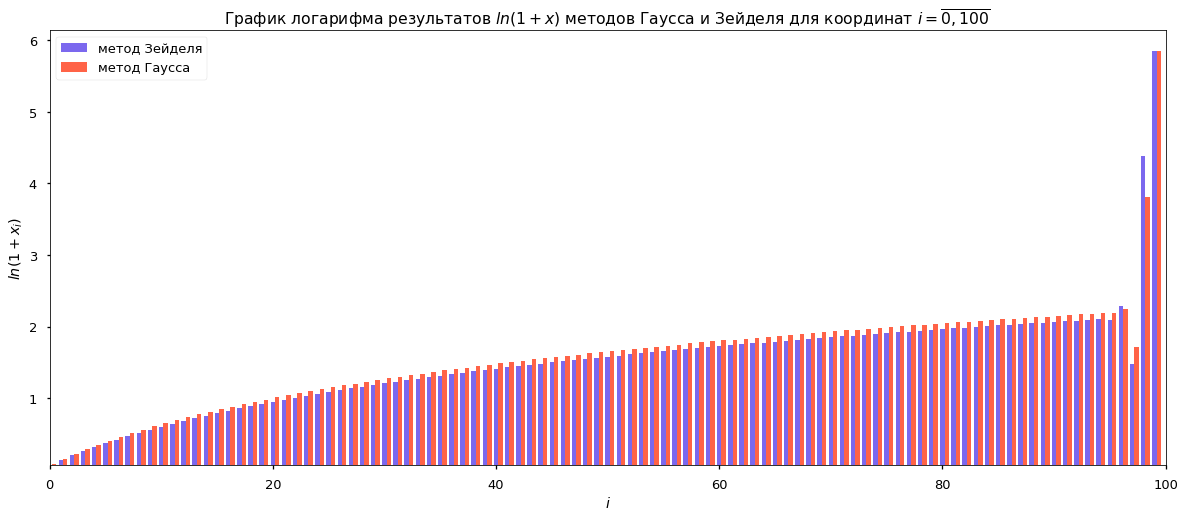

In [250]:
data_gaus = [np.log(1+abs(x)) for x in gauss_res]
data_seid = [np.log(1+abs(x)) for x in seidel_res]
plt.figure(figsize=(20, 8))
plt.ylim((0.95 * min(data_gaus+data_seid), 1.05 * max(data_gaus+data_seid)))
plt.xlim((0, 100))
plt.title("График логарифма результатов $ln(1+x)$ методов Гаусса и Зейделя для координат $i = \overline{0,100}$")
plt.xlabel("$i$")
plt.ylabel("$ln(1+x_i)$")
plt.bar(range(len(data_seid)), data_seid, align='center', color = 'mediumslateblue', width=0.4, label='метод Зейделя');
plt.bar(np.arange(0.4, len(data_gaus)), data_gaus, align='center', color = 'tomato', width=0.4, label='метод Гаусса');
plt.legend();

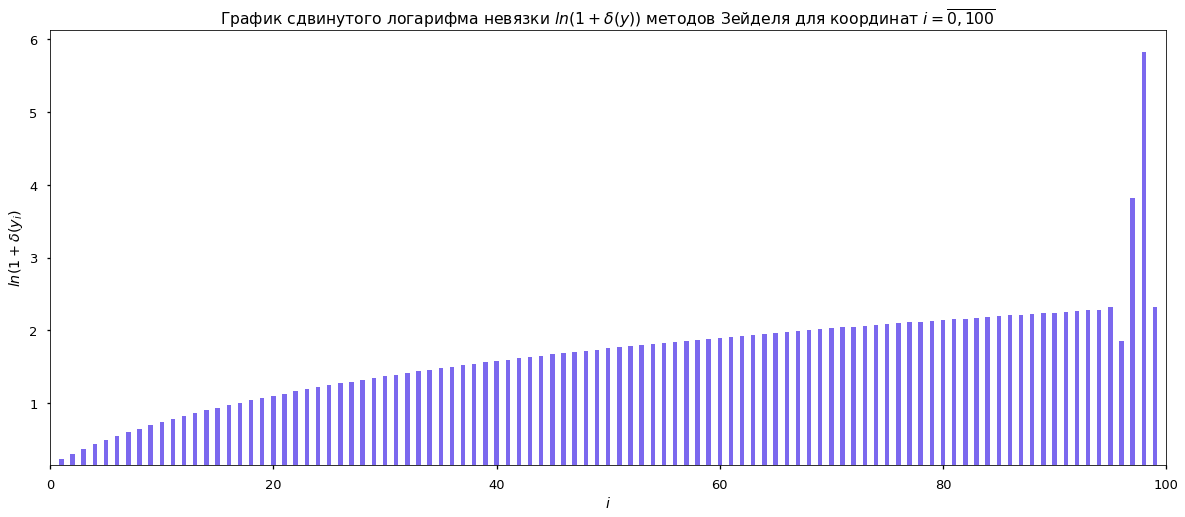

In [260]:
data_seid = [np.log(1+abs(x)) for x in error(A, seidel_res, b)]
plt.figure(figsize=(20, 8))
plt.ylim((0.95 * min(data_seid), 1.05 * max(data_seid)))
plt.xlim((0, 100))
plt.title("График сдвинутого логарифма невязки $ln(1+\delta(y))$ методов Зейделя для координат $i = \overline{0, 100}$")
plt.xlabel("$i$")
plt.ylabel("$ln(1+\delta(y_i)$")

plt.bar(range(len(data_seid)), data_seid, align='center', color = 'mediumslateblue', width=0.4);

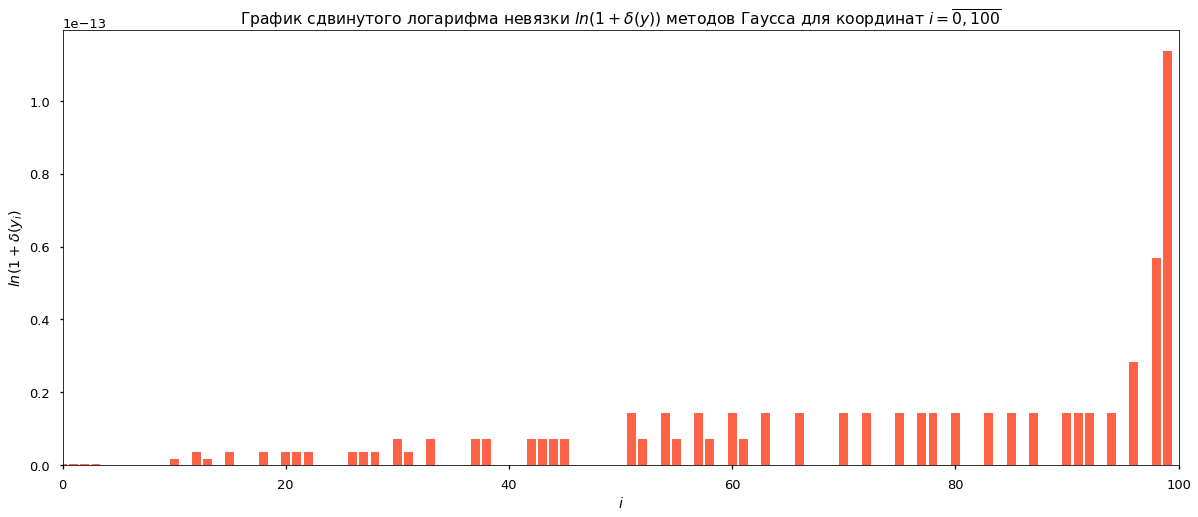

In [261]:
data_gaus = [np.log(1+abs(x)) for x in error(A, gauss_res, b)]
plt.figure(figsize=(20, 8))
plt.ylim((0.95 * min(data_gaus), 1.05 * max(data_gaus)))
plt.xlim((0, 100))
plt.title("График сдвинутого логарифма невязки $ln(1+\delta(y))$ методов Гаусса для координат $i = \overline{0, 100}$")
plt.xlabel("$i$")
plt.ylabel("$ln(1+\delta(y_i)$")

plt.bar(range(len(data_gaus)), data_gaus, align='center', color = 'tomato');

**Вывод:**
1. Имеет место серьезное отличие в значениях $x_{99}$ в результатах двух методов.
2. Невязка метода Зейделя описывается функциональной зависимость относительно индекса (_exp_), присутсвует рост неустойки с увеличением индекса в столбце ответов. Имеют место выбросы в последних координатах.
3. Невязка метода Гаусса описывается дискретной функцией относительно индексов вектора ответов. В последних координатах присутсвуют выбросы.

### Результаты 
_Оценим невязку используя, используя $MAE$ (средняя абсолютная ошибка) к вектору истинных ответов $b$ и ответам $b_0$, полученным с помощью выбранного метода._

In [269]:
gaus_mae = np.mean([abs(x) for x in error(A, gauss_res, b)])
seid_mae = np.mean([abs(x) for x in error(A, seidel_res, b)])
print('MAE(м.Гаусса) = %.4e\nMAE(м.Зейделя) = %0.4f' %(gaus_mae, seid_mae))

MAE(м.Гаусса) = 5.9464e-15
MAE(м.Зейделя) = 8.3497


_Комментарий:_
Столь существенное различие в первую очередь обуславливается наличием существенных выбросов в 98-ой, 99-ой координатах вектора невязки в методе Зейделя. Эта особенность заметна на графиках. 